# 2. EDA on the ML dataset

This notebook contians the exploratory data analysis on the films dataset.

Using the CPI data, we can adjust the budget and revenue into real dollars. Use this equation:

$x_{t_f} = x_{t_f}\frac{CPI_{t_f}}{CPI_{t_s}} $

where $x_{t_f}$ is the dollar amount now, $x_{t_s}$ is the dollar amount at the release date, $CPI_{t_f}$ is the Consumer Price Index now and $CPI_{t_s}$ is the Consumer Price Index at the release date.

In [ ]:
# for the sake of development, use this magic command to solve slow suggestion
%config Completer.use_jedi = False

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('max_columns', 150)

On reading in the data, there are some features that will be created. These are

* `profit` and `profit_class`,
* drilling into `release_date` by extracting `year` and `month`,
* `cast_crew_sum_pop` and `cast_crew_product_pop` from the cast and crew popularities.

The budget and revenue is adjusted here as mentioned above.

Several columns are dropped given they do not add any value. These are `id`, `tmdbId`, `popularity` and `year`.

In [3]:
def to_date(x):
    return datetime.strptime(x[:-2]+'01', '%Y-%m-%d')

#
df = pd.read_csv('prod-movies/movies.csv'
                , converters = {'release_date': to_date})
df['profit'] = df['revenue'] - df['budget']
df['profit_class'] = df['profit'].apply(lambda x: 1 if x < 0 else 0)

df['year'] = df['release_date'].dt.year
df['month'] = df['release_date'].dt.strftime('%b')

df.drop(['id','tmdbId','popularity', 'year'], axis=1, inplace=True)

In [4]:
df['cast_crew_sum_pop'] = df['director_pop'] + df['avg_actor_pop'] + df['avg_writer_pop']
df['cast_crew_product_pop'] = df['director_pop'] * df['avg_actor_pop'] * df['avg_writer_pop']

In [5]:
def cpi_adjust(row, CPI_tf):
    """
    Function to adjust the dollar amounts of previous years by the Consumer
    Price Index.
    
    x_tf = x_ts (CPI_tf / CPI_ts)
    
    Args:
    - row: the row of data sent to the function
    - CPI_tf: most recent CPI
    """
    CPI_ts = row['CPIAUCSL']
    x_ts = row.iloc[0]
    
    x_tf = x_ts * (CPI_ts / CPI_tf)
    return x_tf
    

In [6]:
# adjust the revenue and budget to current day values
CPI_tf = df['CPIAUCSL'].max()

df['budget'] = df[['budget', 'CPIAUCSL']].apply(cpi_adjust
                                                , args=(CPI_tf ,), axis=1)
df['revenue'] = df[['revenue', 'CPIAUCSL']].apply(cpi_adjust
                                                  , args=(CPI_tf ,), axis=1)

# no longer need CPI data
df.drop('CPIAUCSL', axis=1, inplace=True)

## EDA - High Level Overview of the Data

### 1. Summary statistics of the data

In [7]:
df.describe()

,budget,revenue,runtime,num_prods,num_languages,director_pop,num_writers,avg_writer_pop,max_writer_pop,min_writer_pop,sum_actor_pop,avg_actor_pop,max_actor_pop,min_actor_pop,UNRATE,PCE,profit,profit_class,cast_crew_sum_pop,cast_crew_product_pop
count,5.579000e+03,5.579000e+03,5579.000000,5579.000000,5579.000000,5579.000000,5579.000000,5579.000000,5579.000000,5579.000000,5579.000000,5579.000000,5579.000000,5579.000000,5579.000000,5579.000000,5.579000e+03,5579.000000,5579.000000,5579.000000
mean,2.519240e+07,7.309815e+07,109.991576,3.441477,1.489156,2.121568,2.060047,1.041169,1.979608,1.239822,16.695785,5.565262,8.976599,2.876935,6.118516,8294.883205,6.204823e+07,0.300054,8.727999,21.399272
std,3.458169e+07,1.477052e+08,21.077954,2.291254,0.948484,2.228899,1.458330,1.071556,1.939398,1.362361,10.619324,3.539775,6.716860,2.115103,1.691939,3505.897572,1.468563e+08,0.458322,4.990494,87.838710
min,3.546867e-01,3.546867e-01,0.000000,1.000000,1.000000,0.600000,1.000000,0.200000,0.600000,0.600000,0.600000,0.200000,0.600000,0.600000,3.400000,588.700000,-1.657101e+08,0.000000,1.000000,0.024000
25%,4.611265e+06,5.519509e+06,96.000000,2.000000,1.000000,0.884000,1.000000,0.400000,0.828000,0.600000,8.724500,2.908167,4.352000,1.279500,4.800000,5460.200000,-1.846820e+06,0.000000,5.218667,1.564029
50%,1.287304e+07,2.183716e+07,106.000000,3.000000,1.000000,1.428000,2.000000,0.684667,1.400000,0.732000,14.860000,4.953333,7.584000,2.300000,5.600000,9122.100000,1.275659e+07,0.000000,7.676333,4.801679
75%,3.116027e+07,7.555426e+07,120.000000,4.000000,2.000000,2.341000,3.000000,1.263500,2.273000,1.388500,22.387000,7.462333,11.400000,3.899000,7.200000,11004.100000,6.525956e+07,1.000000,11.189000,14.284579
max,3.300606e+08,2.341225e+09,339.000000,26.000000,10.000000,26.885000,24.000000,10.833667,26.885000,17.438000,90.203000,30.067667,43.284000,19.097000,10.800000,14880.500000,2.550965e+09,1.000000,52.876333,4337.711242


**Actionable Insights**:

* Notably, the runtime has a minimum of zero. This is not possible in the use case, and so is dealt with as a null value. The median value will be used to impute these missing values.

* Revenue and budget both have minimum values of 1. I'm sure Hollywood would love \\$1 budgets, and I'm certain they'd hate \\$1 revenues. Investigate the distributions of these features to see if there are rows that should be dropped.


5 films with a zero runtime


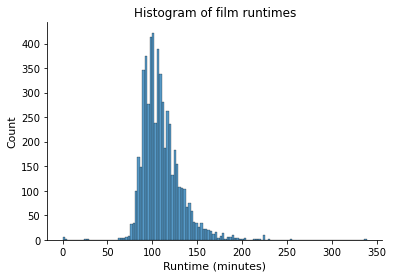

In [8]:
# check how many films have a zero run time
print(f"{df[df['runtime']==0].shape[0]} films with a zero runtime")

# plot the distribution
plt.figure(figsize=(6,4))
plt.xlabel('Runtime (minutes)', fontdict={'fontsize':11})
plt.ylabel('Count', fontdict={'fontsize':11})
plt.title('Histogram of film runtimes', fontdict={'fontsize': 12})
sns.histplot(df.runtime)
sns.despine(right=True)

**ACTION**: impute zero runtime values here

In [9]:
# imputing the runtimes
# df.query('runtime == 0')
df['runtime'].replace(to_replace=0, value=df['runtime'].median(), inplace=True)

Further investigate the distributions of budget and revenue

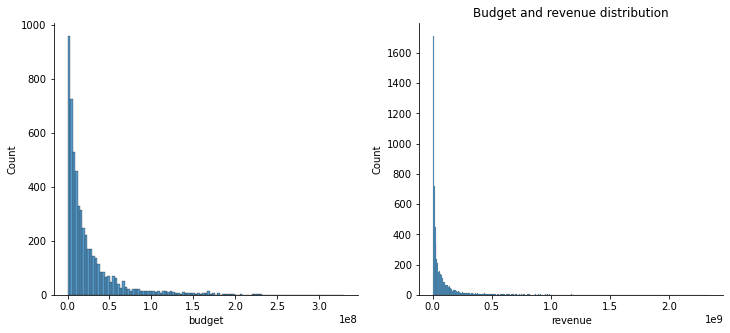

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
plt.title("Budget and revenue distribution")
sns.histplot(df['budget'], ax=ax[0])
sns.histplot(df['revenue'], ax=ax[1])
sns.despine(right=True)
plt.show()

We see that both features have a very heavy right skew, with long tails. See what this looks like as a logarithm plot.

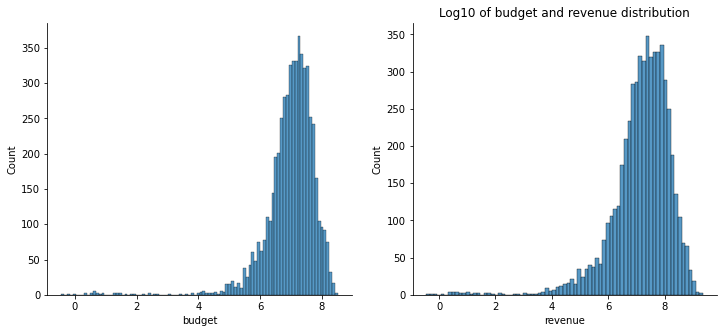

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
plt.title("Log10 of budget and revenue distribution")
sns.histplot(df['budget'].apply(math.log10), ax=ax[0])
sns.histplot(df['revenue'].apply(math.log10), ax=ax[1])
sns.despine(right=True)
plt.show()

The revenue of the films goes up to $10^9$, with the majority of films earning a revenue below that $1,000,000,000 (billion-dollar) threshold. Outliers on both ends should be investigated.

<AxesSubplot:title={'center':'Logarithmic budget and revenue distributions'}, xlabel='Log (base 10) of $', ylabel='Count'>

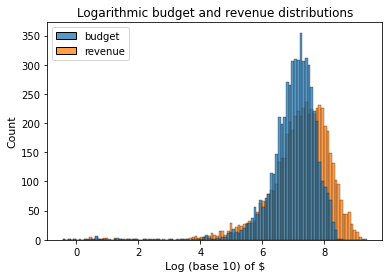

In [12]:
plt.figure(figsize=(6,4))
plt.xlabel('Log (base 10) of $', fontdict={'fontsize':11})
plt.ylabel('Count', fontdict={'fontsize':11})
plt.title('Logarithmic budget and revenue distributions'
          , fontdict={'fontsize': 12})
dfCopy = df.copy()
# dfCopy = df[df['revenue']<=10000000000].copy()
sns.histplot([dfCopy.budget.apply(lambda x: math.log10(x))
              , dfCopy.revenue.apply(lambda x: math.log10(x))])
# sns.despine(right=True)

In [13]:
for thresh in [10**2,10**3, 10**4, 10**5, 10**6, 10**7, 10**8, 10**9, 10**10]:
    print("Films under ${} revenue - {:.2f}%".format(
        thresh, 100*df[df['revenue']<thresh].shape[0]/df.shape[0]
    ))

Films under $100 revenue - 0.65%
Films under $1000 revenue - 0.75%
Films under $10000 revenue - 1.20%
Films under $100000 revenue - 3.28%
Films under $1000000 revenue - 9.98%
Films under $10000000 revenue - 34.95%
Films under $100000000 revenue - 80.68%
Films under $1000000000 revenue - 99.61%
Films under $10000000000 revenue - 100.00%


The above output and figures should it would be wise to drop the 1.20% that earnt below $10,000.

In [14]:
df = df.query('10000 <= revenue')

Better! Now look at the budgets.

In [15]:
for thresh in [10**2,10**3, 10**4, 10**5, 10**6, 10**7, 10**8, 10**9]:
    print("Films under ${} budget - {:.2f}%".format(
        thresh, 100*df[df['budget']<thresh].shape[0]/df.shape[0]
    ))

Films under $100 budget - 0.07%
Films under $1000 budget - 0.07%
Films under $10000 budget - 0.20%
Films under $100000 budget - 1.05%
Films under $1000000 budget - 7.44%
Films under $10000000 budget - 42.63%
Films under $100000000 budget - 95.19%
Films under $1000000000 budget - 100.00%


In a similar way, removing the bottom 1.05% will focus the data where the bulk is.

In [16]:
df = df.query('100000 <= budget')

<AxesSubplot:title={'center':'Logarithmic budget and revenue distributions'}, xlabel='Log (base 10) of $', ylabel='Count'>

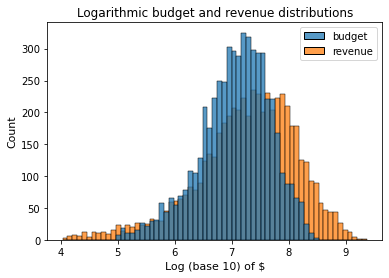

In [17]:
plt.figure(figsize=(6,4))
plt.xlabel('Log (base 10) of $', fontdict={'fontsize':11})
plt.ylabel('Count', fontdict={'fontsize':11})
plt.title('Logarithmic budget and revenue distributions'
          , fontdict={'fontsize': 12})
dfCopy = df.copy()
sns.histplot([dfCopy.budget.apply(lambda x: math.log10(x))
              , dfCopy.revenue.apply(lambda x: math.log10(x))])
# sns.despine(right=True)

### 2. Feature correlations

Seaborn has a useful heatmap funcitonality that can provide good visual insights into the correlations between variables. The red squares have a strong positive correlation. The lighter colours have no correlation. Darker blue means a stronger negative correlation.

<AxesSubplot:title={'center':'Heatmap of feature correlations'}>

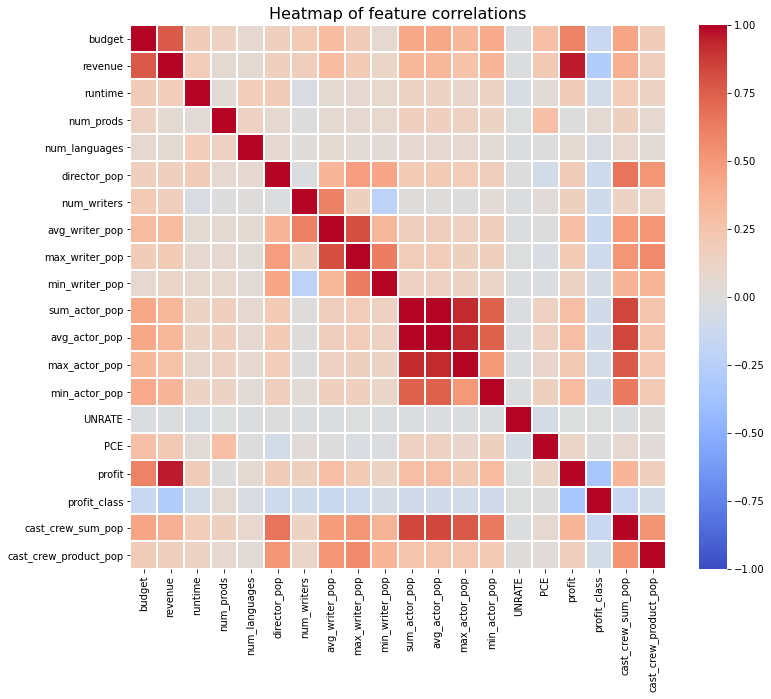

In [18]:
# fig, ax = plt.subplots(figsize=(12,10))

plt.figure(figsize=(12,10))
plt.title('Heatmap of feature correlations', fontdict={'fontsize':16})
sns.heatmap(df.corr(), linewidths=1, cmap='coolwarm', vmin=-1, vmax=1)

Narrow the scope to the cast and crew popularities as there are high correlations between some of these features.

<AxesSubplot:title={'center':'Heatmap of feature correlations'}>

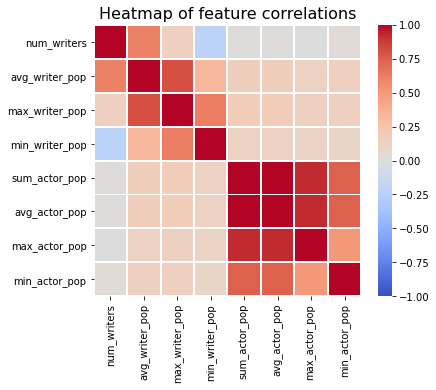

In [19]:
# fig, ax = plt.subplots(figsize=(12,10))
dfCopy = df[['writers', 'num_writers', 'avg_writer_pop', 'max_writer_pop',
       'min_writer_pop', 'actors', 'sum_actor_pop', 'avg_actor_pop',
       'max_actor_pop', 'min_actor_pop']]
plt.figure(figsize=(6,5))
plt.title('Heatmap of feature correlations', fontdict={'fontsize':16})
sns.heatmap(dfCopy.corr(), linewidths=1, cmap='coolwarm', vmin=-1, vmax=1)

The top left quadrant (on the writer popularities) looks good enough to keep. The bottom right quadrant (actor popularities) would be better served with dropping at least one feature.

**Actionable Insights**:

* `sum_actor_pop` is directly correlated with `avg_actor_pop`. Drop the former.

In [20]:
df.drop(['sum_actor_pop'], axis=1, inplace=True)

### 3. Investigate the distributions of some of the features

Look at the distributions of some of the features, like we did with the revenue and budget features above. Anticipating a right skew on some of the features, plot the normal distribution and a log-transformed distribution.

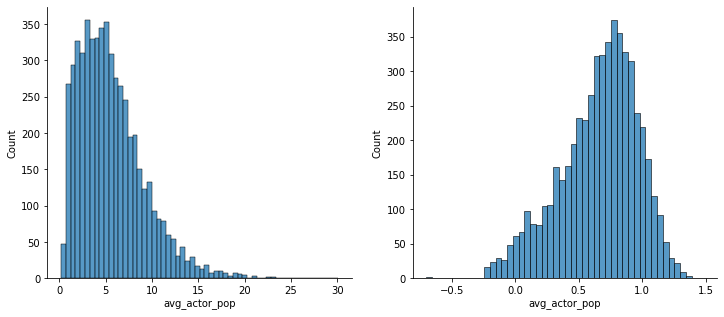

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.histplot(df['avg_actor_pop'], ax=ax[0])
sns.histplot(df['avg_actor_pop'].apply(math.log10), ax=ax[1])
sns.despine(right=True)
plt.show()

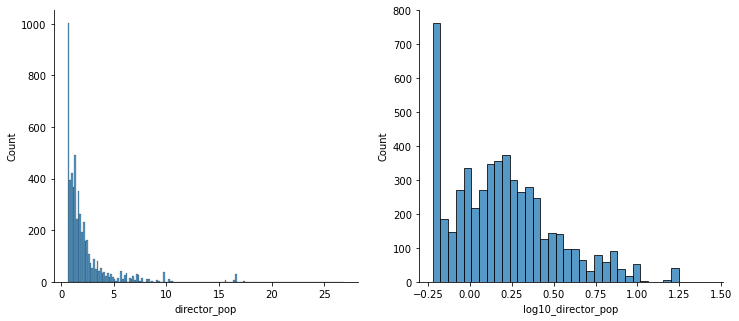

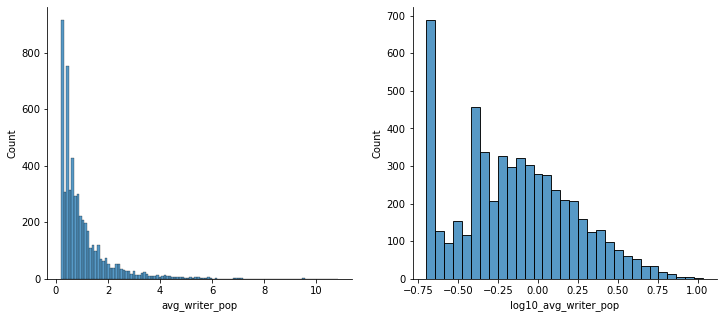

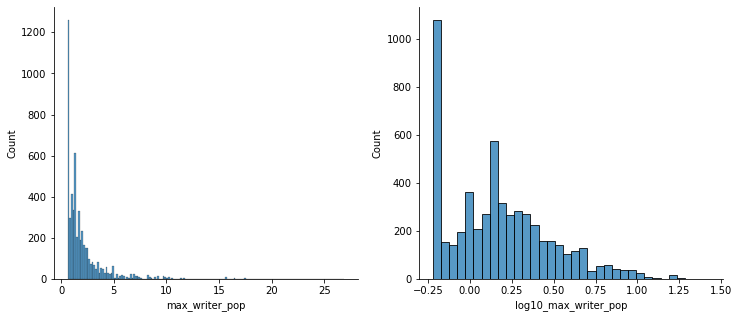

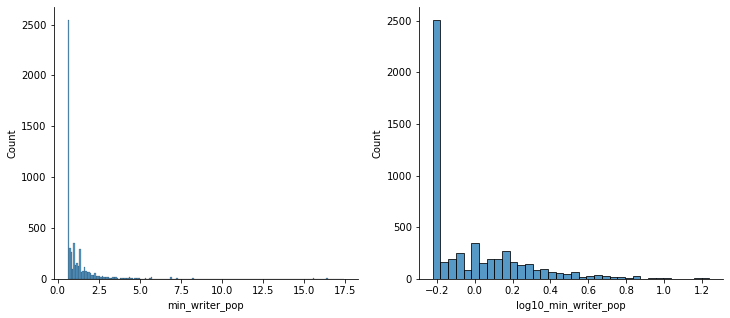

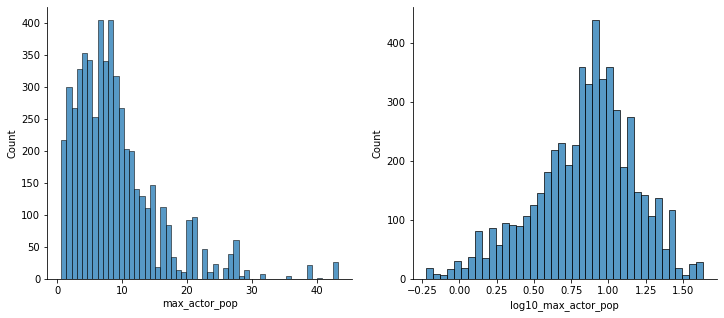

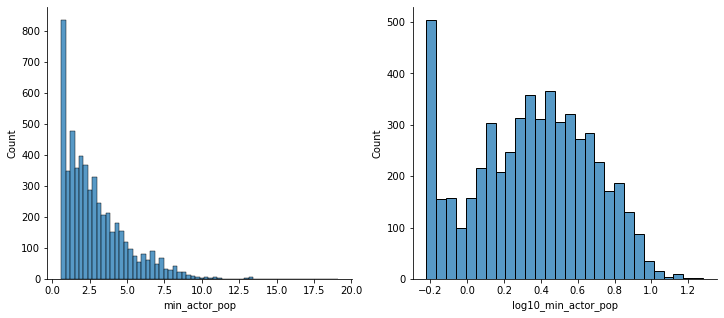

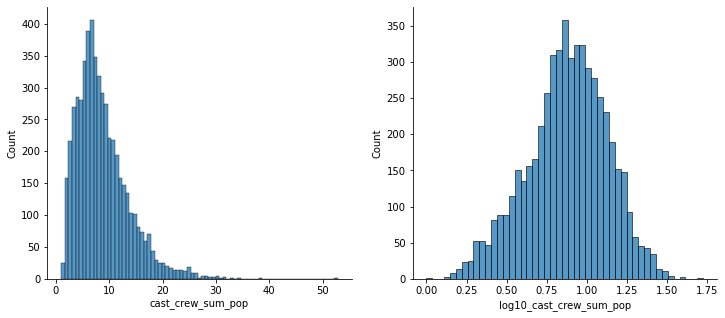

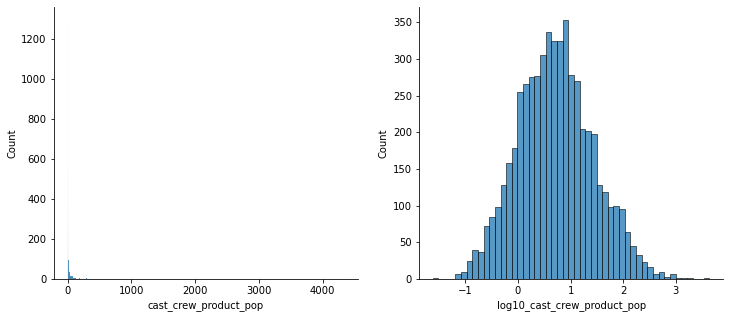

In [22]:
for col in [
    "director_pop", "avg_writer_pop", "max_writer_pop", "min_writer_pop"
    , "max_actor_pop", "min_actor_pop"
    , 'cast_crew_sum_pop', 'cast_crew_product_pop'
]:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    dfLogarithm = df.copy()
    dfLogarithm['log10_'+col] = dfLogarithm[col].apply(
        lambda x: math.log10(x)
    )
    sns.histplot(dfLogarithm[col], ax=ax[0])
    sns.histplot(dfLogarithm['log10_'+col], ax=ax[1])
    sns.despine(right=True)
    plt.show()

**Actionable insights**:

* all columns are improved with the logarithm transform. Replace all of these columns with a $log_{10}$ transform of them
* remove `min_writer_pop`. Around half of the data for that feature was in a single bucket on the far left of the distribution. Doubtful if will be a great predictor.

Each of the remaining columns (apart from `runtime`) investigated here shall have a logarithm applied to them in the data preprocessing so the machine learning algorithm has data closer to a normal distribution to work with.

In [23]:
df.drop('min_writer_pop', axis=1, inplace=True)

# code to transform columns
for col in [
    "budget", "director_pop", "avg_writer_pop"
    , "max_writer_pop", "avg_actor_pop", "max_actor_pop"
    , "min_actor_pop", 'cast_crew_sum_pop'
    , 'cast_crew_product_pop'
]:
    df['log10_'+col] = df[col].apply(lambda x: math.log10(x))
    df.drop(col, axis=1, inplace=True)

### 4. Categorical Columns

In [24]:
dfCat = df.drop(df.describe().columns, axis=1).copy()

In [25]:
dfCat.head(1)

,original_language,original_title,release_date,prod_comp_names,prod_comp_cntry,language,genres,director,writers,actors,month
0,en,Toy Story,1995-10-01,Pixar,US,English,Adventure|Animation|Children|Comedy|Fantasy,John Lasseter,Andrew Stanton;Bud Luckey;Joss Whedon;Joel Coh...,Tom Hanks;Tim Allen;Don Rickles,Oct


Some of the columns we could One Hot Encode. Do this with original language, director and month. Find out how many unique values for each.

In [26]:
print(f"{df['director'].nunique()} unique directors")
print(f"{df['original_language'].nunique()} unique original languages")

2351 unique directors
38 unique original languages


We definitely cannot add 2,351 columns to give a flag for each director. We will have to only keep the ones that are in the top 100 of frequency.

In [27]:
from sklearn.preprocessing import OneHotEncoder

# create dataframes with these categorical features encoded as binary values
ONE_HOT_COLS = ['original_language', 'director', 'month']

# HANDLE THE COLUMNS THAT CAN UNDERGO ONE HOT ENCODING
cat_dfs = []
for col in ONE_HOT_COLS:
    onehot_encoder = OneHotEncoder()
    col_encoded = onehot_encoder.fit_transform(df[[col]])
    col_encoded_df = pd.DataFrame(col_encoded.toarray()
                                 , columns=[col+"_"+str(x) for x in
                                            onehot_encoder.categories_[0]])

    if col=='director':
        # find the most proflific directors, take the top 100
        directors = col_encoded_df.transpose().sum(axis=1)
        directors = directors.sort_values(ascending=False)[:100].index
        col_encoded_df = col_encoded_df[directors]

    cat_dfs.append(col_encoded_df)

# append the columns onto the main dataframe
for i, col in enumerate(ONE_HOT_COLS):
    df = df.merge(cat_dfs[i], left_on=df.index, right_on=cat_dfs[i].index)
    df.drop([col, 'key_0'], axis=1, inplace=True)

In [28]:
df.head(1)

,original_title,release_date,revenue,runtime,num_prods,prod_comp_names,prod_comp_cntry,language,num_languages,genres,writers,num_writers,actors,UNRATE,PCE,profit,profit_class,log10_budget,log10_director_pop,log10_avg_writer_pop,log10_max_writer_pop,log10_avg_actor_pop,log10_max_actor_pop,log10_min_actor_pop,log10_cast_crew_sum_pop,log10_cast_crew_product_pop,original_language_ar,original_language_bm,original_language_ca,original_language_cn,original_language_cs,original_language_da,original_language_de,original_language_el,original_language_en,original_language_es,original_language_fi,original_language_fr,original_language_he,original_language_hi,original_language_hu,original_language_id,original_language_it,original_language_ja,original_language_ko,original_language_ku,original_language_ml,original_language_nb,original_language_nl,original_language_no,original_language_pl,original_language_pt,original_language_ro,original_language_ru,original_language_sr,original_language_sv,original_language_ta,original_language_te,original_language_th,original_language_tl,original_language_tr,original_language_uk,original_language_ur,original_language_zh,director_Steven Spielberg,director_Clint Eastwood,director_Woody Allen,director_Ridley Scott,director_Martin Scorsese,director_Steven Soderbergh,director_Ron Howard,director_Robert Zemeckis,director_Tim Burton,director_Brian De Palma,director_Spike Lee,...,director_Stephen Herek,director_Jonathan Frakes,director_Garry Marshall,director_Shawn Levy,director_Rob Cohen,director_Peter Jackson,director_David Cronenberg,director_Chris Columbus,director_Tyler Perry,director_M. Night Shyamalan,director_Edward Zwick,director_Phillip Noyce,director_Roland Emmerich,director_Lasse Hallström,director_David Fincher,director_Rob Reiner,director_John McTiernan,director_Kevin Smith,director_Tim Story,director_Bobby Farrelly,director_Jon Turteltaub,director_Gore Verbinski,director_Wolfgang Petersen,director_Guy Ritchie,director_Kunihiko Yuyama,director_Wes Anderson,director_F. Gary Gray,director_Raja Gosnell,director_Peter Hyams,director_Mike Nichols,director_Michael Mann,director_Stephen Frears,director_Gus Van Sant,director_Todd Phillips,director_Christopher Nolan,director_Bruno Dumont,director_Harold Ramis,director_Dennis Dugan,director_Roger Donaldson,director_Terry Gilliam,director_Peter Berg,director_Hayao Miyazaki,director_James Mangold,director_Martin Campbell,director_Guillermo del Toro,director_Paul Verhoeven,director_Bryan Singer,director_Sidney Lumet,director_Malcolm D. Lee,director_Roman Polanski,director_Marc Forster,director_Joe Dante,director_Jay Roach,director_Brett Ratner,director_James Wan,director_William Friedkin,director_Alan Parker,director_John Singleton,director_Stephen Hopkins,director_Sydney Pollack,director_John Woo,director_James Foley,director_Mark Waters,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep
0,Toy Story,1995-10-01,2.215460e+08,81.0,1,Pixar,US,English,1,Adventure|Animation|Children|Comedy|Fantasy,Andrew Stanton;Bud Luckey;Joss Whedon;Joel Coh...,5,Tom Hanks;Tim Allen;Don Rickles,5.5,5013.9,343554033.0,0,7.250232,0.525304,0.652182,0.822822,1.051268,1.42951,0.393048,1.280904,2.228754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Now handle the other categorical columns. For example, for actors we need to find out how many unique names there are in the data. Go through all the rows an create a dictionary for them, then find the length of it.

In [29]:
counts_dict = {}
for i, row in df[['actors']].iterrows():
    for key in row[0].split(';'):
        try:
            count = counts_dict[key]
            counts_dict[key] += 1
        except:
            counts_dict[key] = 1
print('Number of unique actors = ', len(counts_dict))

Number of unique actors =  5752


There are 5,752 unique actors in the data. Like with directors, we cannot have a flag for all of them. Therefore, keep only the top 100 most popular. Do this for the other columns as well.

In [30]:
def expand_categories(row, cat_set):
    """
    Function to expand the categories data into a ;-separated list to include
    a value with each of the categories
    """
    my_str = ""
    
    # iterate through all possible categories
    for category in cat_set:
        # check for matches in this row
        my_str+= category
        if category in row:
            my_str += '-1;'
        else:
            my_str += '-0;'
            
    return my_str[:-1]

In [31]:
# HANDLE THE COMPLICATED CATEGORICAL COLUMNS, WITH A ; SEPARATING ENTRIES
OTHER_CATEGORICAL_COLS = ['genres', 'actors', 'writers', 'prod_comp_names'
                          , 'prod_comp_cntry', 'language']

df_cat = df[OTHER_CATEGORICAL_COLS].copy()
# clean the genres data so it is in the same format as all the other columns
df_cat['genres'] = df_cat['genres'].apply(lambda x: x.replace('|', ';'))

category_counts = {}

# loop through each columns
for col in df_cat.columns:
    # generate the set of unique values for the column
    counts_dict = {}
    for i, row in df_cat[[col]].iterrows():
        for key in row[0].split(';'):
            try:
                count = counts_dict[key]
                counts_dict[key] += 1
            except:
                counts_dict[key] = 1

    category_counts[col] = counts_dict

# We have the counts for each of the category values in a dictionary
# Order the dictionary to take those only in the top 100, say
category_dict = {}
for key in category_counts:
    if len(category_counts[key]) > 100:
        df_tmp = pd.DataFrame.from_dict(category_counts[key]
                                       , orient='index'
                                       , columns=['count'])
        df_tmp = df_tmp.sort_values('count', ascending=False).iloc[:100]
        category_dict[key] = list(df_tmp.index)
    else:
        category_dict[key] = [k for k in category_counts[key]]

cat_dfs = []

for col in df_cat.columns:
    i=0
    df_cat[col] = df_cat[col].apply(lambda x: expand_categories(x, category_dict[col]))
    categories = df_cat[col].str.split(';', expand=True)
    categories.columns = [col+"_"+str(value) for value in categories.columns]

    for cat_col in categories:
        categories[cat_col] = pd.to_numeric(categories[cat_col].apply(lambda x: x[-1]))
        i += 1

    categories.columns = [(col+"_"+item).replace(' ', '_') for item in category_dict[col]]

    cat_dfs.append(categories)

for i, col in enumerate(OTHER_CATEGORICAL_COLS):
    df = df.merge(cat_dfs[i], left_on=df.index, right_on=cat_dfs[i].index)
    df.drop([col, 'key_0'], axis=1, inplace=True)

In [32]:
df.shape

(5334, 649)

These 649 columns are too many for a machine learning algorithm with this number of rows. In the preprocessing, we will have to reduce this down. Do this by only keeping the columns that have a count of non-zero entries that will meet a certain threshold for frequency in the data - say, 2% of all rows.

## Factorise the code into a function to be used in preprocessing

In [33]:
from load_data import load_data
df = load_data()

In [34]:
def preprocess(df):
    """
    Function to preprocess the data ahead of ML
    """ 
        
    ##########################################################################
    # adjust the data for inflation
    CPI_tf = df['CPIAUCSL'].max()
    df['budget'] = df[['budget', 'CPIAUCSL']].apply(
        cpi_adjust
        , args=(CPI_tf ,)
        , axis=1
    )
    df['revenue'] = df[['revenue', 'CPIAUCSL']].apply(
        cpi_adjust
        , args=(CPI_tf ,)
        , axis=1
    )
    # no longer need CPI data
    df.drop('CPIAUCSL', axis=1, inplace=True)
        
    ########################################################################## 
    # add in useful features about the cast and crew
    df['cast_crew_sum_pop'] = (
        df['director_pop'] + df['avg_actor_pop'] + df['avg_writer_pop']
    )
    df['cast_crew_product_pop'] = (
        df['director_pop'] * df['avg_actor_pop'] * df['avg_writer_pop']
    )
    df['runtime'].replace(to_replace=0, value=df['runtime'].median(), inplace=True)
    df = df.query('10000 <= revenue').copy()
    df = df.query('100000 <= budget').copy()
    df.drop('sum_actor_pop', axis=1, inplace=True)
    df.drop('min_writer_pop', axis=1, inplace=True)

    # code to transform some numerical columns with a logarithm
    for col in [
        "budget", "director_pop", "avg_writer_pop"
        , "max_writer_pop", "avg_actor_pop", "max_actor_pop"
        , "min_actor_pop", 'cast_crew_sum_pop'
        , 'cast_crew_product_pop'
    ]:
        df['log10_'+col] = df[col].apply(lambda x: math.log10(x))
        df.drop(col, axis=1, inplace=True)
        
     # drop some of the categorical columns
    DROP_COLUMNS = [col for col in df.columns if col[:3]=="lan"]
    df.drop(DROP_COLUMNS, axis=1, inplace=True)
    
    DROP_COLUMNS = [col for col in df.columns if col[:4]=="year"]
    df.drop(DROP_COLUMNS, axis=1, inplace=True)

    # loop through the columns we want to aggregate
    for col_type in [
        "original_language_"
        , "prod_comp_cntry_"
        , "prod_comp_names_"
        , "writers_"
        , "actors_"
        , "genres_"
        , "director_"
    ]:
        # create a dictionary of each unique value and its frequency
        val_freq = {}
        for col in df.columns:
            if col.startswith(col_type):
                val_freq[col] = df[col].sum()

        # create a dataframe from this dictionary; sort by count
        counts = pd.DataFrame.from_dict(
            val_freq
            , orient='index'
            , columns=['count']
        ).sort_values('count', ascending=False)
        counts['frac'] = counts['count'].apply(lambda x: 100*x / df.shape[0])

        # handle special case of production company country
        if col_type == "prod_comp_cntry_":
            DROP_COLUMNS = [col for col in counts.index][3:]

        # handle special case of directors
        elif col_type == "director_":
            DIRECTOR_COLS = [col for col in df.columns
                             if col.startswith("director_")
                             and col!="director_pop"]
            df['established_director'] = df[DIRECTOR_COLS].max(axis=1)
            DROP_COLUMNS = DIRECTOR_COLS

        # handle special case of actors
        elif col_type == "actors_":
            ACTORS_COLS = [col for col in df.columns if "actors" in col]
            df['num_top_100_actors'] = df[ACTORS_COLS].sum(axis=1)
            DROP_COLUMNS = ACTORS_COLS
        
        # handle all the other cases
        else:
            DROP_COLUMNS = [col for col in counts.query('frac < 2').index]


        df.drop(DROP_COLUMNS, axis=1, inplace=True)
        
    return df

def cpi_adjust(row, CPI_tf):
    """
    Function to adjust the dollar amounts of previous years by the Consumer
    Price Index.
    
    x_tf = x_ts (CPI_tf / CPI_ts)
    
    Args:
    - row: the row of data sent to the function
    - CPI_tf: most recent CPI
    """
    CPI_ts = row['CPIAUCSL']
    x_ts = row.iloc[0]
    
    x_tf = x_ts * (CPI_ts / CPI_tf)
    return x_tf
    

In [35]:
preprocess(df).head()

,id,original_title,popularity,release_date,revenue,runtime,num_prods,num_languages,tmdbId,num_writers,UNRATE,PCE,class,original_language_en,original_language_fr,original_language_hi,month_Apr,month_Aug,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep,genres_Adventure,genres_Animation,genres_Children,genres_Comedy,genres_Fantasy,genres_Drama,genres_Romance,genres_Action,genres_Crime,genres_Thriller,genres_Mystery,genres_Sci-Fi,genres_Musical,genres_Horror,genres_War,genres_IMAX,prod_comp_names_Warner_Bros._Pictures,prod_comp_names_Universal_Pictures,prod_comp_names_Columbia_Pictures,prod_comp_names_Paramount,prod_comp_names_20th_Century_Fox,prod_comp_names_New_Line_Cinema,prod_comp_names_Walt_Disney_Pictures,prod_comp_names_Canal+,prod_comp_names_Metro-Goldwyn-Mayer,prod_comp_names_Touchstone_Pictures,prod_comp_names_Relativity_Media,prod_comp_names_Miramax,prod_comp_names_Sony_Pictures,prod_comp_names_Dune_Entertainment,prod_comp_cntry_US,prod_comp_cntry_GB,prod_comp_cntry_FR,log10_budget,log10_director_pop,log10_avg_writer_pop,log10_max_writer_pop,log10_avg_actor_pop,log10_max_actor_pop,log10_min_actor_pop,log10_cast_crew_sum_pop,log10_cast_crew_product_pop,num_top_100_actors,established_director
0,862.0,Toy Story,112.136,1995-10-01,2.215460e+08,81.0,1,1,862.0,5,5.5,5013.9,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,7.250232,0.525304,0.652182,0.822822,1.051268,1.429510,0.393048,1.280904,2.228754,1,0.0
1,8844.0,Jumanji,22.333,1995-12-01,1.562650e+08,104.0,4,2,8844.0,3,5.6,5097.5,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,7.587154,0.471732,0.260389,0.629817,0.876776,1.069668,0.318272,1.090399,1.608897,1,0.0
2,31357.0,Waiting to Exhale,6.240,1995-12-01,4.843322e+07,127.0,1,1,31357.0,2,5.6,5097.5,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,6.978361,0.725830,-0.175874,0.146438,0.524006,0.754578,0.199206,0.969789,1.073962,0,0.0
3,949.0,Heat,28.870,1995-12-01,1.114540e+08,170.0,3,2,949.0,1,5.6,5097.5,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,7.552392,0.962985,0.485863,0.962985,1.037811,1.211307,0.914079,1.364620,2.486659,3,1.0
4,11860.0,Sabrina,11.671,1995-12-01,3.191459e+07,127.0,7,2,11860.0,5,5.6,5097.5,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,7.537669,0.031408,0.337858,0.350829,0.858918,1.054498,0.697142,1.020292,1.228185,1,1.0
